In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

IMPORTING DATA

In [2]:
data = pd.read_csv('caseStudyData.csv')

EXPLORING RAW DATA

First, I wanted to check to make sure that there no classification errors in the current data against the current table provided. 

In [3]:
 for i in range(1,7):
     print('hit class {} max: {}'.format(i, str(data[data['hitClass']== i].loc[:,'launchAngle'].max())))

hit class 1 max: -0.00048131
hit class 2 max: 5.999547
hit class 3 max: 14.99967
hit class 4 max: 23.999855
hit class 5 max: 49.99377
hit class 6 max: 86.19314


Everyhing looks to match the current table thresholds. Next, I wanted to look at variable distributions and check for missing values

In [4]:
data.describe()

,hitClass,exitSpeed,launchAngle,direction,distance,playingLevel
count,42353.000000,42353.000000,42353.000000,42353.000000,42353.000000,42353.000000
mean,3.003896,24.212230,11.102125,1.362638,34.835475,1.264633
std,1.406767,15.702177,16.367450,17.329804,33.995818,0.946256
min,1.000000,0.000000,-78.520900,-178.531387,0.000000,0.000000
25%,2.000000,0.000000,0.000000,-4.235783,0.000000,1.000000
50%,3.000000,30.150870,7.792350,0.000000,27.635597,1.000000
75%,4.000000,36.642030,21.793545,8.828101,63.050034,2.000000
max,6.000000,60.846760,86.193140,178.301315,139.527985,3.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42353 entries, 0 to 42352
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   hitClass      42353 non-null  int64  
 1   exitSpeed     42353 non-null  float64
 2   launchAngle   42353 non-null  float64
 3   direction     42353 non-null  float64
 4   distance      42353 non-null  float64
 5   playingLevel  42353 non-null  int64  
dtypes: float64(4), int64(2)
memory usage: 1.9 MB


A few possible data issues standout after looking at the distributions. The lower quartile of exitSpeed and distance look to be completely 0 values. Both of these will need to be explored in more detail to determine if they are data errors. It is not possible for a ball to make contact with a bat and have no speed.

The direction and launchAngle looks to contain possible values with no obvious measurement errors.

In [6]:
data[data['exitSpeed']==0].describe()

,hitClass,exitSpeed,launchAngle,direction,distance,playingLevel
count,11244.0,11244.0,11244.0,11244.0,11244.0,11244.000000
mean,2.0,0.0,0.0,0.0,0.0,1.319993
std,0.0,0.0,0.0,0.0,0.0,0.933751
min,2.0,0.0,0.0,0.0,0.0,0.000000
25%,2.0,0.0,0.0,0.0,0.0,1.000000
50%,2.0,0.0,0.0,0.0,0.0,1.000000
75%,2.0,0.0,0.0,0.0,0.0,2.000000
max,2.0,0.0,0.0,0.0,0.0,3.000000


In [7]:
data[data['distance']==0].describe()

,hitClass,exitSpeed,launchAngle,direction,distance,playingLevel
count,11244.0,11244.0,11244.0,11244.0,11244.0,11244.000000
mean,2.0,0.0,0.0,0.0,0.0,1.319993
std,0.0,0.0,0.0,0.0,0.0,0.933751
min,2.0,0.0,0.0,0.0,0.0,0.000000
25%,2.0,0.0,0.0,0.0,0.0,1.000000
50%,2.0,0.0,0.0,0.0,0.0,1.000000
75%,2.0,0.0,0.0,0.0,0.0,2.000000
max,2.0,0.0,0.0,0.0,0.0,3.000000


There seems to definitely be data errors. There are a total of 11,244 entries that have an exitSpeed and Distance of 0. It does not make sense for a hit to have no speed or distance. 0 distance could be possible if launchAngle was -90 but 0 speed is not possible on a 

In addition to exitSpeed and distance showing zeros on these entries, the 2 other hit variables all show 0's too. Given all data readings show as zeros, I am confident that there was input errors for the hit data and they can be removed from the data set.

In [8]:
data.groupby('hitClass').count()

,exitSpeed,launchAngle,direction,distance,playingLevel
hitClass,,,,,
1,5525,5525,5525,5525,5525
2,14453,14453,14453,14453,14453
3,6619,6619,6619,6619,6619
4,6729,6729,6729,6729,6729
5,8142,8142,8142,8142,8142
6,885,885,885,885,885


In [9]:
df = data[(data['exitSpeed']!= 0) & 
          (data['launchAngle']!= 0) & 
          (data['direction']!= 0) & 
          (data['distance']!= 0)]

In [10]:
df.groupby('hitClass').count()

,exitSpeed,launchAngle,direction,distance,playingLevel
hitClass,,,,,
1,5525,5525,5525,5525,5525
2,3209,3209,3209,3209,3209
3,6619,6619,6619,6619,6619
4,6729,6729,6729,6729,6729
5,8142,8142,8142,8142,8142
6,885,885,885,885,885


filtering for the errorneous data brought down the hits classified as ground balls from 14453 to 3209. Since the launch angle was 0 on all of them they were categorized as ground balls per the table.

In [11]:
df.describe()

,hitClass,exitSpeed,launchAngle,direction,distance,playingLevel
count,31109.000000,31109.000000,31109.000000,31109.000000,31109.000000,31109.000000
mean,3.366743,32.963469,15.114863,1.855148,47.426368,1.244624
std,1.482689,6.869971,17.437593,20.198019,31.245641,0.949957
min,1.000000,5.200808,-78.520900,-178.531387,0.070527,0.000000
25%,2.000000,28.304895,4.466186,-8.761034,19.586716,1.000000
50%,4.000000,33.924660,15.243434,2.402144,46.783806,1.000000
75%,5.000000,38.139088,25.903866,13.418140,72.619990,2.000000
max,6.000000,60.846760,86.193140,178.301315,139.527985,3.000000


Converting exitSpeed from meters per second to miles per hour and converting distance from meters to feet

In [12]:
df.loc[:,'exitSpeed'] = df.loc[:,'exitSpeed'].apply(lambda x: x * 2.236936)

c:\users\jrbrz\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [13]:
df['exitSpeed'].describe()

count    31109.000000
mean        73.737171
std         15.367686
min         11.633875
25%         63.316239
50%         75.887293
75%         85.314698
max        136.110308
Name: exitSpeed, dtype: float64

It looks like there may be some questionable exitSpeed data towards the max. There have only been about 10 balls hit with an exit Speed in the 120s over the last few MLB seasons. The 136mph max could be a cause for concern if there are lot of other reading close to it. 

In [14]:
df[df['exitSpeed']>=120]

,hitClass,exitSpeed,launchAngle,direction,distance,playingLevel
1119,1,136.110308,-10.860388,-3.793450,4.664407,0
20919,1,125.379032,-5.716215,11.860381,6.572350,0
34048,1,120.768202,-5.972075,7.332520,10.447422,1


It looks like there are 3 hits with readings over 120 and they are from Youth or high school. Due to the almost non-exsistent small sample size, I am going to chalk them up to reading errors and remove them from the data set. 

In [15]:
df = df[df['exitSpeed'] <120]

In [16]:
df.loc[:,'distance'] = df.loc[:,'distance'].apply(lambda x: x * 3.28084)

In [17]:
df['distance'].describe()

count    31106.000000
mean       155.611044
std        102.508680
min          0.231388
25%         64.326471
50%        153.519499
75%        238.264878
max        457.768994
Name: distance, dtype: float64

The farthest home run in 2020 was around 500ft so the conversion from meters to feet looks good.

In [18]:
headers = list(data.columns)

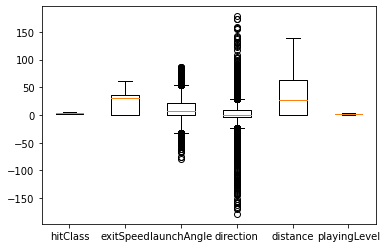

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.boxplot(data)
ax.set_xticklabels(headers)
plt.show()

I am going to be using a k-means model to classify a hit. For this model, predictor variables with differing scale and magnitude can greatly impact the performance of this model; data on extreme scales compared to others would have  larger influence on the model if they are used raw. As seen above in the boxplots, our variables have this issue. I will center all of the variables to a mean = 0, and a standard deviation = 1. I will also need to convert our quantitative variable, playingLevel, into dummy variables.

The pair plots below highlights the issue raised in the prompt. There are clearly a high number of balls that are scorched which are categorized as dribblers. By using K-means, I hope to be able to uncover better clusters of hits that are more representative of the actual hit type. New data will be able to be fed to the model to categorize it. 

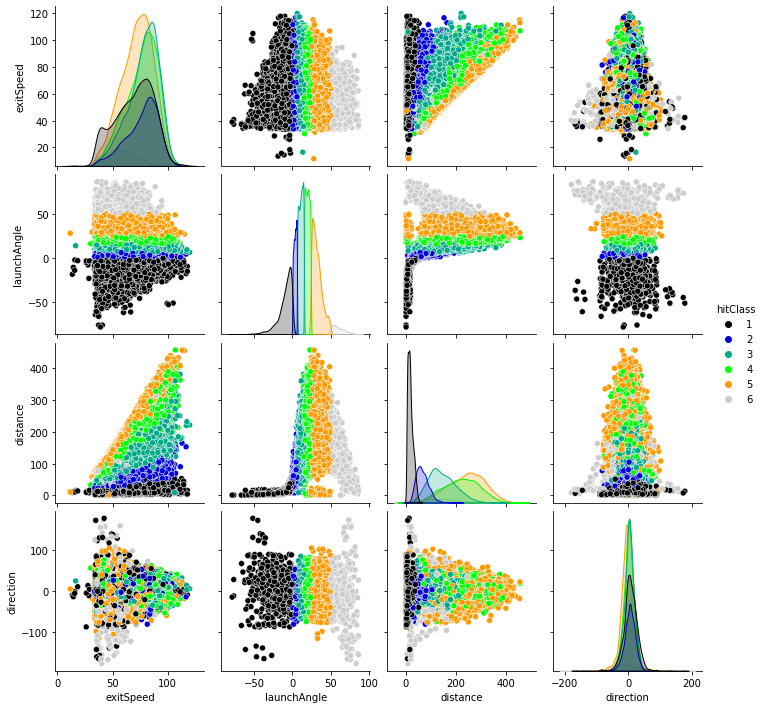

In [20]:
sns.pairplot(data= df, hue='hitClass', vars=['exitSpeed','launchAngle','distance','direction'],
            palette= 'nipy_spectral')

Creating dummy variabls and scaling the variables.

In [24]:
dummies = pd.get_dummies(df['playingLevel'])
dummies = dummies.astype({0:float,1:float,2:float,3:float})
dummies.columns = ['youth','highSchool','college','pro']
scaledVars = pd.DataFrame(scale(df[['exitSpeed','launchAngle','direction','distance']]))
scaledVars.columns = ['exitSpeedScaled','launchAngleScaled','directionScaled','distanceScaled']
scaledVars.describe()

,exitSpeedScaled,launchAngleScaled,directionScaled,distanceScaled
count,3.110600e+04,3.110600e+04,3.110600e+04,3.110600e+04
mean,6.729438e-16,2.374491e-16,-2.512689e-18,-1.249492e-16
std,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00
min,-4.043108e+00,-5.370158e+00,-8.930657e+00,-1.515795e+00
25%,-6.782552e-01,-6.101018e-01,-5.255765e-01,-8.905201e-01
50%,1.402233e-01,7.387244e-03,2.708029e-02,-2.040392e-02
75%,7.541136e-01,6.187432e-01,5.726553e-01,8.063235e-01
max,3.004964e+00,4.076230e+00,8.735606e+00,2.947680e+00


Recombining the transformed data

In [25]:
modelData = scaledVars.merge(dummies.reset_index(drop=True), left_index=True, right_index=True)
modelData = modelData.merge(df['hitClass'].reset_index(drop=True),left_index=True, right_index=True)

There isn't going to be a classic test of model accuracy because the goal of this model is to create a better classification system. With that in mind, I can't test the classification against old hitClass classifications because we are looking to improve the current system, not predict to match it.

Below, I am splitting out the hitClass data so that a K-means model can be created using our dummy variables and scaled exitSpeed, launchAngle, direction, and distance variables. I am then creating the k-means model, fitting it to a train set  and predicting on a test set. 

In [26]:
X = modelData.drop(['hitClass'], axis=1)
#X = modelData.drop(['directionScaled'], axis=1)
y = modelData['hitClass']
#Xtrain, Xtest, yTrain, yTest = train_test_split(X, y, test_size= 0.15)
#k = round(math.sqrt(len(y)),0) #knn k
k = 6  #k-means k matching the number of hit types
kmeans = KMeans(n_clusters =k, random_state=17)
kmeans.fit(X)
yHat = kmeans.predict(X)
X.loc[:,'newHitClass']= yHat


The pairplot below is based on the model and the 6 new clusters it has created. After reviewing them, I noticed that the direction variable is creating some unwanted groupings heavily based on left or right direction. These categories are not really contributing to what we are looking to classify so I will rerun the model without the direction variable included. Including them is creating a lot of noise - looking at exit speed and laucnh angle in the pair plot below shows it. The directional clusters are causing multiple classifications for very similar hits. Direction is an important variable of hitting but not for the classifications we are looking to obtain.

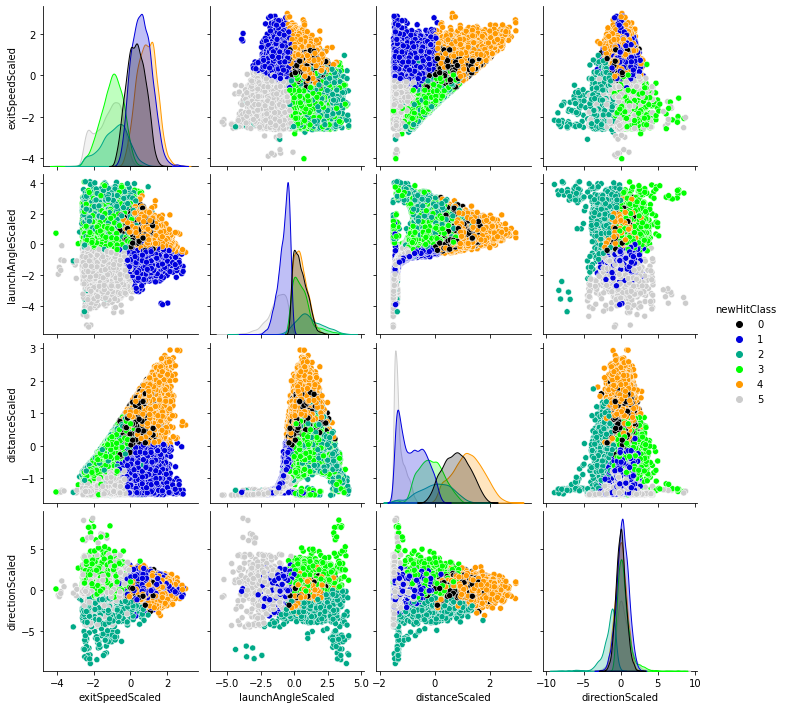

In [187]:
sns.pairplot(data= X, hue='newHitClass', 
             vars=['exitSpeedScaled','launchAngleScaled','distanceScaled','directionScaled'],
            palette= 'nipy_spectral')

Rebuilding the k-means models without the direction variable.

In [27]:
X = modelData.drop(['hitClass', 'directionScaled'], axis=1)
#X = modelData.drop(['directionScaled'], axis=1)
y = modelData['hitClass']
#Xtrain, Xtest, yTrain, yTest = train_test_split(X, y, test_size= 0.15)
#k = round(math.sqrt(len(y)),0) #knn k
k = 6  #k-means k matching the number of hit types
kmeans = KMeans(n_clusters =k, random_state=17)
kmeans.fit(X)
yHat = kmeans.predict(X)
X.loc[:,'newHitClass']= yHat

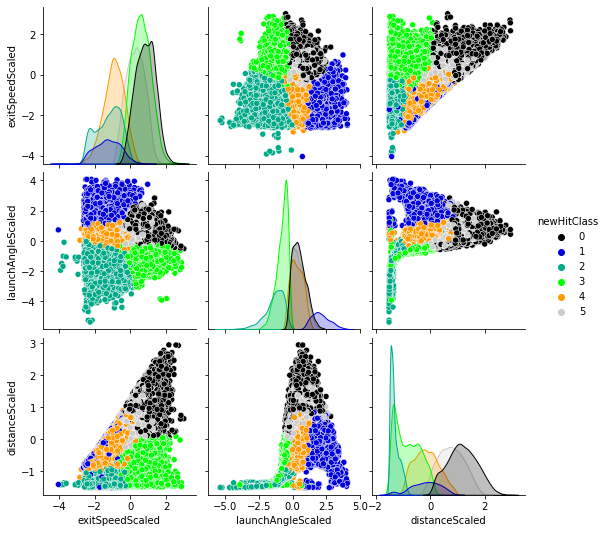

In [28]:
sns.pairplot(data= X,hue='newHitClass', 
             vars=['exitSpeedScaled','launchAngleScaled','distanceScaled'],
            palette= 'nipy_spectral')


We now have a model that does not have the unwanted impact from left to right hit placement. We also see better separtion across all 3 density plots compared to our original hit classifier on only launchAngle. Exit speed looks to have a much greater impact now. There aren't 110mph dribblers. Looking at exitSpeed and launchAngle shows much tighter groupings wihtout as much overlap.
    DRIBBLERS: dark green(2) lowest angle:lowest speed:shortest distance
    GROUND BALL: neon green(3) low-mid angle:high speed:low-mid distance
    LOW LINE DRIVES: orange(4) mid angle:low-mid speed:low-mid distance
    HIGH LINE DRIVES: black(0) mid-high angle: mid-high speed: farthest distance
    FLY BALL: grey (5) mid-high angle: mid speed: mid-high distance
    POP UP: blue(1) highest angles:low-mid speed:low-mid distance
 
 
The overlap and noise is driven by the playing level. If another pairplot is ran including them, the effect of playing level can be seen. Looking at distance and playing level, it is clear that the farther hit ground balls are a result of the younger players and as you progress toward pro, the farther hit balls become the high line drives. There is also a concerning issue with the model looking at highschool. They seem to have almost all of the fly balls categorized specificially to them.

c:\users\jrbrz\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


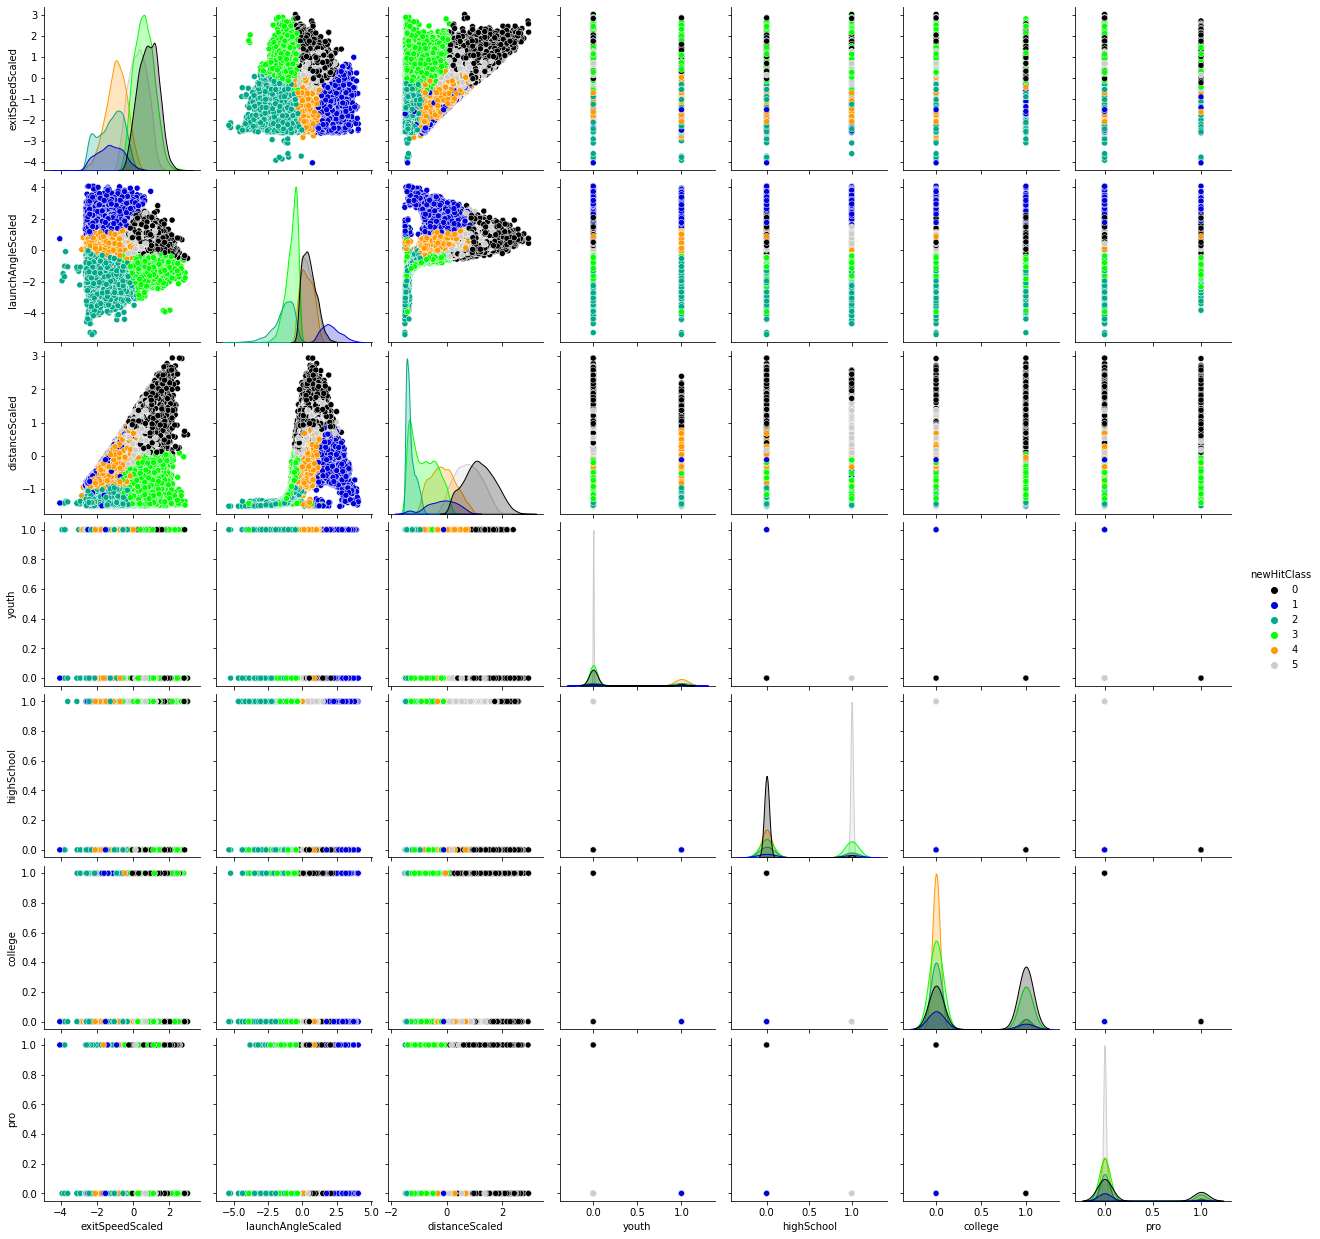

In [190]:
sns.pairplot(data= X,hue='newHitClass', 
             vars=['exitSpeedScaled','launchAngleScaled','distanceScaled',
                  'youth','highSchool','college','pro'],
            palette= 'nipy_spectral')

In [191]:
X.groupby(['newHitClass','youth','highSchool','college','pro']).count()

exitSpeedScaled  launchAngleScaled  \
newHitClass youth highSchool college pro                                       
0           0.0   0.0        0.0     1.0             1942               1942   
                             1.0     0.0             3947               3947   
                  1.0        0.0     0.0              206                206   
            1.0   0.0        0.0     0.0              599                599   
1           0.0   0.0        0.0     1.0              182                182   
                             1.0     0.0              389                389   
                  1.0        0.0     0.0              647                647   
            1.0   0.0        0.0     0.0              449                449   
2           0.0   0.0        0.0     1.0              233                233   
                             1.0     0.0              487                487   
                  1.0        0.0     0.0             1175               1175   
            1.0   0.0        0.0     0.0             1830               1830   
3           0.0   0.0        0.0     1.0             1014               1014   
                             1.0     0.0             2489               2489   
                  1.0        0.0     0.0             3581               3581   
            1.0   0.0        0.0     0.0              586                586   
4           0.0   0.0        0.0     1.0              304                304   
                             1.0     0.0              327                327   
                  1.0        0.0     0.0              730                730   
            1.0   0.0        0.0     0.0             3981               3981   
5           0.0   0.0        0.0     1.0               36                 36   
                  1.0        0.0     0.0             5968               5968   
            1.0   0.0        0.0     0.0                4                  4   

                                          distanceScaled  
newHitClass youth highSchool college pro                  
0           0.0   0.0        0.0     1.0            1942  
                             1.0     0.0            3947  
                  1.0        0.0     0.0             206  
            1.0   0.0        0.0     0.0             599  
1           0.0   0.0        0.0     1.0             182  
                             1.0     0.0             389  
                  1.0        0.0     0.0             647  
            1.0   0.0        0.0     0.0             449  
2           0.0   0.0        0.0     1.0             233  
                             1.0     0.0             487  
                  1.0        0.0     0.0            1175  
            1.0   0.0        0.0     0.0            1830  
3           0.0   0.0        0.0     1.0            1014  
                             1.0     0.0            2489  
                  1.0        0.0     0.0            3581  
            1.0   0.0        0.0     0.0             586  
4           0.0   0.0        0.0     1.0             304  
                             1.0     0.0             327  
                  1.0        0.0     0.0             730  
            1.0   0.0        0.0     0.0            3981  
5           0.0   0.0        0.0     1.0              36  
                  1.0        0.0     0.0            5968  
            1.0   0.0        0.0     0.0               4

Looking at the chart above, the visual inspection of highschool fly ball looks to be accurate. Youth players only have 4 categotized as fly balls, college has none, and pro only has 36.  This seems highly suspect and is likley driven by the playing level categories causing issues. I am going to break out the data into 4 sets for each playing level to make 4 models; 1 for each level. Since I am ungrouping the data, I will need to start over with the unscaled data, group into my 4 sets and then scale the variables in their individuals groups.

In [29]:
dfs = {'youth':df[df['playingLevel']==0], 
       'highSchool':df[df['playingLevel']==1],
       'college':df[df['playingLevel']==2],
       'pro':df[df['playingLevel']==3]
      }
scaledDfs = {}
for k, v in dfs.items():
    scaledVars = pd.DataFrame(scale(dfs[k][['exitSpeed','launchAngle','direction','distance']]))
    scaledVars.columns = ['exitSpeedScaled','launchAngleScaled','directionScaled','distanceScaled']
    scaledDfs[k] = scaledVars.merge(dfs[k]['hitClass'].reset_index(drop=True),left_index=True, right_index=True)
    

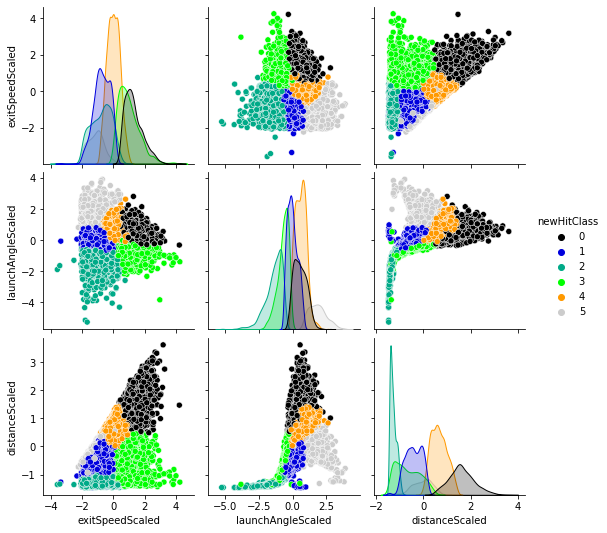

In [37]:
Xyouth= scaledDfs['youth'].drop(['hitClass', 'directionScaled'], axis=1)
yYouth = scaledDfs['youth']['hitClass']
k = 6  #k-means k matching the number of hit types
kmeansYouth = KMeans(n_clusters =k, random_state=17)
kmeansYouth.fit(Xyouth)
yHatYouth = kmeansYouth.predict(Xyouth)
Xyouth.loc[:,'newHitClass']= yHatYouth
sns.pairplot(data= Xyouth,hue='newHitClass', 
             vars=['exitSpeedScaled','launchAngleScaled','distanceScaled'],
            palette= 'nipy_spectral')

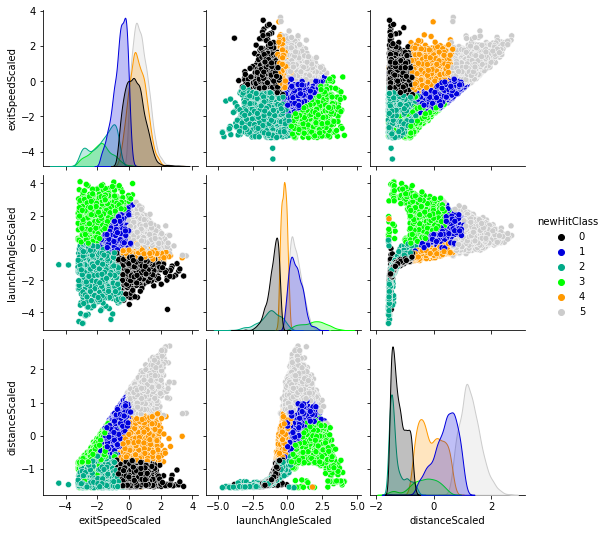

In [38]:
XhighSchool= scaledDfs['highSchool'].drop(['hitClass', 'directionScaled'], axis=1)
yhighSchool = scaledDfs['highSchool']['hitClass']
k = 6  #k-means k matching the number of hit types
kmeansHighSchool = KMeans(n_clusters =k, random_state=17)
kmeansHighSchool.fit(XhighSchool)
yHathighSchool = kmeansHighSchool.predict(XhighSchool)
XhighSchool.loc[:,'newHitClass']= yHathighSchool
sns.pairplot(data= XhighSchool,hue='newHitClass', 
             vars=['exitSpeedScaled','launchAngleScaled','distanceScaled'],
            palette= 'nipy_spectral')

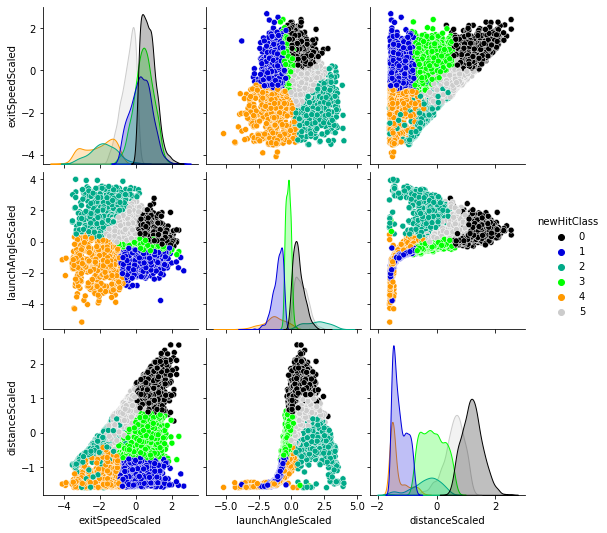

In [39]:
Xcollege= scaledDfs['college'].drop(['hitClass', 'directionScaled'], axis=1)
ycollege = scaledDfs['college']['hitClass']
k = 6  #k-means k matching the number of hit types
kmeansCollege = KMeans(n_clusters =k, random_state=17)
kmeansCollege.fit(Xcollege)
yHatcollege = kmeansCollege.predict(Xcollege)
Xcollege.loc[:,'newHitClass']= yHatcollege
sns.pairplot(data= Xcollege,hue='newHitClass', 
             vars=['exitSpeedScaled','launchAngleScaled','distanceScaled'],
            palette= 'nipy_spectral')

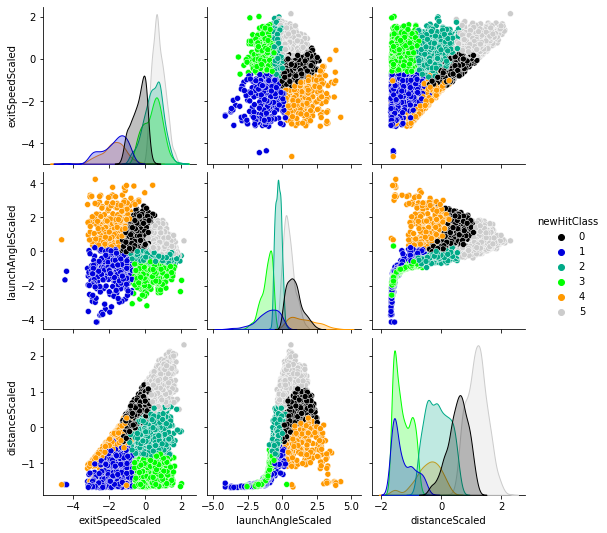

In [41]:
Xpro= scaledDfs['pro'].drop(['hitClass', 'directionScaled'], axis=1)
ypro = scaledDfs['pro']['hitClass']
k = 6  #k-means k matching the number of hit types
kmeansPro = KMeans(n_clusters =k, random_state=17)
kmeansPro.fit(Xpro)
yHatpro = kmeansPro.predict(Xpro)
Xpro.loc[:,'newHitClass']= yHatpro
sns.pairplot(data= Xpro,hue='newHitClass', 
             vars=['exitSpeedScaled','launchAngleScaled','distanceScaled'],
            palette= 'nipy_spectral')

The seperation at playing level is promising. Every playing level has hits in all 6 categories with little overlap. The categories look to make logical sense by looking at the data distribution across them for our predictor data.  Using the pro pairplot legend:

    

In [42]:
centersYouth = kmeansYouth.cluster_centers_
centersHighSchool = kmeansHighSchool.cluster_centers_
centersCollege = kmeansCollege.cluster_centers_
centersPro = kmeansPro.cluster_centers_

In [52]:
pd.DataFrame(kmeansCollege.cluster_centers_, 
             index= ['High Liners', 'Grounders','Pop up','Low Liners', 'Dribblers' ,'Fly Ball'],
             columns= ['exitSpeed','launchAngle', 'distance']).sort_values(by='launchAngle')

,exitSpeed,launchAngle,distance
Dribblers,-2.027928,-1.355942,-1.341846
Grounders,0.298921,-1.059934,-1.255195
Low Liners,0.445220,-0.260712,-0.124939
High Liners,0.713188,0.522805,1.206253
Fly Ball,-0.425217,0.748787,0.590517
Pop up,-1.796686,1.882335,-0.353050


In [54]:
pd.DataFrame(kmeansPro.cluster_centers_, 
             index= ['Fly Ball', 'Dribblers','Low Liners','Grounders','Pop up', 'High Liners'],
             columns= ['exitSpeed','launchAngle', 'distance']).sort_values(by='launchAngle')

,exitSpeed,launchAngle,distance
Grounders,0.406385,-1.167820,-1.285696
Dribblers,-1.747480,-1.085802,-1.269032
Low Liners,0.438597,-0.308570,-0.118871
High Liners,0.735003,0.462709,1.184300
Fly Ball,-0.373521,0.844167,0.541927
Pop up,-1.763012,1.539837,-0.438482
